In [1]:
# display the origin video
from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="miscs/cxk.mp4" type="video/mp4">
</video>
""")

Below is 2d process
Below is 3d process
=> Read 3D estimator config from models/openpose_video_pose_243f/video_pose.yaml.
{'DATASET': {'CAM_PARAMS': '/home/kevin/public98/3dpose/Dataset/h36m/cameras.h5',
             'IMAGE_HEIGHT': 1002,
             'IMAGE_WIDTH': 1000,
             'INPUT_LEFT_JOINTS': [5, 6, 7, 12, 13, 14, 16, 18, 19, 20, 21],
             'INPUT_RIGHT_JOINTS': [2, 3, 4, 9, 10, 11, 15, 17, 22, 23, 24],
             'INPUT_ROOT': '/home/kevin/HDD/h36m_dataset/2D_openpose',
             'IN_CHANNEL': 2,
             'IN_JOINT': 25,
             'NAME': 'h36m',
             'OUTPUT_LEFT_JOINTS': [4, 5, 6, 11, 12, 13],
             'OUTPUT_RIGHT_JOINTS': [1, 2, 3, 14, 15, 16],
             'OUT_CHANNEL': 3,
             'OUT_JOINT': 17,
             'SEQ_LEN': 243,
             'TARGET_ROOT': '/home/kevin/HDD/h36m_dataset/3D_gt',
             'TEST_FLIP': True,
             'TRAIN_FLIP': True},
 'MODEL': {'ACTIVATION': 'relu',
           'BIAS': True,
           'DROPO

/home/nvidia/projects/video2bvh/utils/camera.py:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(cam_file) as f:


Display 3d_pose gif file.


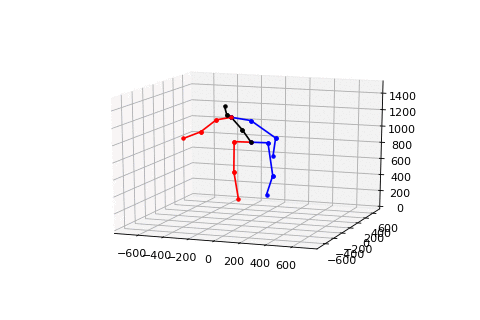

In [1]:
#calculate the pose
from pose_estimator_2d import openpose_estimator
from pose_estimator_3d import estimator_3d
from utils import smooth, vis, camera
from bvh_skeleton import openpose_skeleton, h36m_skeleton, cmu_skeleton

import cv2
import importlib
import numpy as np
import os
from pathlib import Path
from IPython.display import HTML
from IPython.display import Image
from multiprocessing import Process


def process_for_2d(video_file, output_dir):
    e2d = openpose_estimator.OpenPoseEstimator(model_folder='/home/nvidia/projects/openpose/models/') # set model_folder to /path/to/openpose/models
#   video_file = Path('miscs/cxk.mp4') # video file to process
#   output_dir = Path('miscs/cxk_cache')
#   if not output_dir.exists():
#       os.makedirs(output_dir)

    cap = cv2.VideoCapture(str(video_file))
    keypoints_list = []
    img_width, img_height = None, None
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img_height = frame.shape[0]
        img_width = frame.shape[1]

        # returned shape will be (num_of_human, 25, 3)
        # last dimension includes (x, y, confidence)
        keypoints = e2d.estimate(img_list=[frame])[0]
        if not isinstance(keypoints, np.ndarray) or len(keypoints.shape) != 3:
            # failed to detect human
            keypoints_list.append(None)
        else:
            # we assume that the image only contains 1 person
            # multi-person video needs some extra processes like grouping
            # maybe we will implemented it in the future
            keypoints_list.append(keypoints[0])
    cap.release()
    # filter out failed result
    keypoints_list = smooth.filter_missing_value(
        keypoints_list=keypoints_list,
        method='ignore' # interpolation method will be implemented later
    )

    # smooth process will be implemented later

    # save 2d pose result
    pose2d = np.stack(keypoints_list)[:, :, :2]
    pose2d_file = Path(output_dir / '2d_pose.npy')
    np.save(pose2d_file, pose2d)


def process_for_3d(video_file, output_dir):
#   video_file = Path('miscs/cxk.mp4') # video file to process
#   output_dir = Path('miscs/cxk_cache')
    if not output_dir.exists():
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(str(video_file))
    keypoints_list = []
    img_width, img_height = None, None
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img_height = frame.shape[0]
        img_width = frame.shape[1]
    cap.release()
    pose2d_file = Path(output_dir / '2d_pose.npy')

    importlib.reload(estimator_3d)
    e3d = estimator_3d.Estimator3D(
        config_file='models/openpose_video_pose_243f/video_pose.yaml',
        checkpoint_file='models/openpose_video_pose_243f/best_58.58.pth'
    )

    pose2d = np.load(pose2d_file)
    pose3d = e3d.estimate(pose2d, image_width=img_width, image_height=img_height)

    subject = 'S1'
    cam_id = '55011271'
    cam_params = camera.load_camera_params('cameras.h5')[subject][cam_id]
    R = cam_params['R']
    T = 0
    azimuth = cam_params['azimuth']

    pose3d_world = camera.camera2world(pose=pose3d, R=R, T=T)
    pose3d_world[:, :, 2] -= np.min(pose3d_world[:, :, 2]) # rebase the height

    pose3d_file = output_dir / '3d_pose.npy'
    np.save(pose3d_file, pose3d_world)

    h36m_skel = h36m_skeleton.H36mSkeleton()
    gif_file = output_dir / '3d_pose_300.gif' # output format can be .gif or .mp4 

    ani = vis.vis_3d_keypoints_sequence(
        keypoints_sequence=pose3d_world[0:300],
        skeleton=h36m_skel,
        azimuth=azimuth,
        fps=60,
        output_file=gif_file
    )
    HTML(ani.to_jshtml())

    bvh_file = output_dir / f'{video_file.stem}.bvh'
    cmu_skel = cmu_skeleton.CMUSkeleton()
    channels, header = cmu_skel.poses2bvh(pose3d_world, output_file=bvh_file)


if __name__ == "__main__":
    video_file = Path('miscs/cxk.mp4') # video file to process
    output_dir = Path('miscs/cxk_cache')
    if not output_dir.exists():
        os.makedirs(output_dir)
        
    
    print("Below is 2d process")
    p = Process(target = process_for_2d, args = (video_file, output_dir,))
    p.start()
    p.join()
#    process_for_2d(video_file, output_dir)

    print("Below is 3d process")
    p = Process(target = process_for_3d, args = (video_file, output_dir,))
    p.start()
    p.join()
    
    print('Display 3d_pose gif file.')
    # create an Image object with file path and name.
    local_image = Image(filename = output_dir / '3d_pose_300.gif')
    # display the local image in jupyter notebook
    display(local_image)


In [2]:
#compare the result
from IPython.display import HTML

HTML("""
<table>
  <tr>
    <td>
      <video width="320" height="240" controls>
        <source src="miscs/cxk.mp4" type="video/mp4">
      </video>
    </td>
    <td>
      <video width="320" height="240" controls>
        <source src="miscs/cxk_cache/3d_pose_300.mp4" type="video/mp4">
      </video>
    </td>    
  </tr>
</table>
""")